# Pump Control

First, we will import the necessary packages to solve the problems.


In [13]:
from fluids import friction, core, fittings
from fluids.piping import nearest_pipe
from pyfluids import Fluid, FluidsList, Input
import numpy as np
from scipy.optimize import root_scalar
from plotly.subplots import make_subplots

## 1. Pump operating point

Pump H-Q curve and \\(\eta\\)-Q is fitted to the following polynomial.

$$
H = 150 - 20Q^2
$$
$$
\eta = -0.420Q^2 + 1.06Q + 0.188
$$

The maximum flow of the pump is 1.5 m3/s. The pump is unstable over this flow.

The pump is operating at 1170 RPM and pump water at 20<sup>o</sup>C from one reservoir to another 35m higher through 450m steel pipe of nominal diameter 400mm with schedule 40. What is the operating point of the pump? What is the power consumption of the pump?


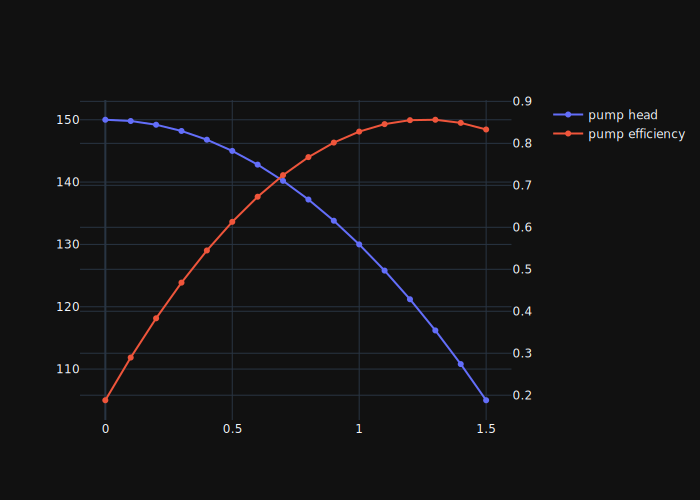

In [14]:
# Let's plot the pump curve first

def get_pump_head_m(vol_flow_m3_per_s) -> float:
    """Returns the pump head"""
    return 150 - 20.0 * np.power(vol_flow_m3_per_s, 2)

def get_pump_efficiency(vol_flow_m3_per_s) -> float:
    """Returns the pump efficiency"""
    return -0.42 * np.power(vol_flow_m3_per_s, 2) + 1.06 * vol_flow_m3_per_s + 0.188

vol_flow_m3_per_s_array = np.linspace(0, 1.5, 16)
pump_head_m_array = get_pump_head_m(vol_flow_m3_per_s_array)
pump_efficiency_array = get_pump_efficiency(vol_flow_m3_per_s_array)
fig = make_subplots(specs=[[dict(secondary_y=True)]])
fig.add_scatter(x=vol_flow_m3_per_s_array, y=pump_head_m_array, name="pump head")
fig.add_scatter(x=vol_flow_m3_per_s_array, y=pump_efficiency_array, name="pump efficiency", secondary_y=True)
fig.show(renderer="svg")


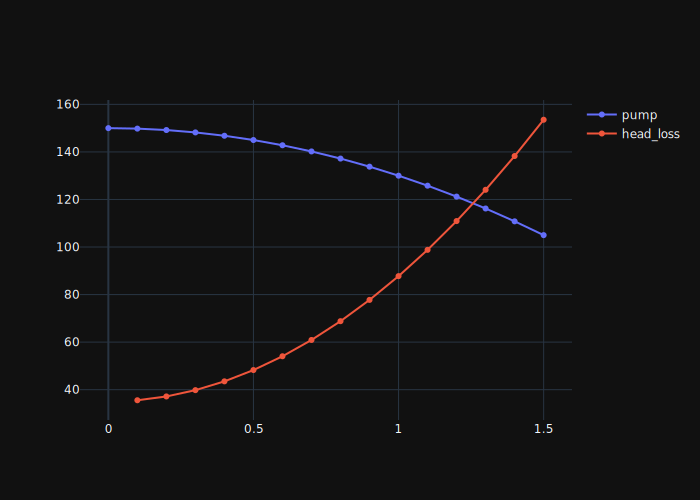

In [15]:
# Let's get the system head loss curve
fluid = Fluid(FluidsList.Water).with_state(Input.pressure(1e5), Input.temperature(20))
_, inner_dia_m, _, _ = nearest_pipe(Di=0.4, schedule="40")
roughness = friction.material_roughness("clean steel pipe")
pipe_section_area_m2 = np.pi * inner_dia_m**2 / 4
h_lift = 35

def get_system_head_m(vol_flow_m3_per_s: float) -> float:
    """Returns the system head loss in meter"""
    pressure_drop = friction.one_phase_dP(
        m=vol_flow_m3_per_s * fluid.density,
        rho=fluid.density,
        mu=fluid.dynamic_viscosity,
        D=inner_dia_m,
        roughness=roughness,
        L=450
    )
    return pressure_drop / fluid.density / 9.81 + h_lift

head_system_m_array = np.array([
    get_system_head_m(vol_flow)
    for vol_flow in vol_flow_m3_per_s_array[1:]
])
fig = make_subplots()
fig.add_scatter(x=vol_flow_m3_per_s_array, y=pump_head_m_array, name="pump")
fig.add_scatter(x=vol_flow_m3_per_s_array[1:], y=head_system_m_array, name="head_loss")
fig.show(renderer="svg")

In [16]:
# Find the flow exactly
def function_to_solve(vol_flow_m3_per_s: float) -> float:
    """Function to solve for flow"""
    pump_head_m = get_pump_head_m(vol_flow_m3_per_s)
    head_loss_m = get_system_head_m(vol_flow_m3_per_s)
    return pump_head_m - head_loss_m

sol = root_scalar(f=function_to_solve, x0=1.4, x1=1.5)
if sol.converged:
    vol_flow_only_pipe_m3_per_s = sol.root
    pump_head_only_pipe_m = get_pump_head_m(vol_flow_only_pipe_m3_per_s)
    efficiency = get_pump_efficiency(vol_flow_only_pipe_m3_per_s)
    power_only_pipe_kw = \
        fluid.density * 9.81 \
        * vol_flow_only_pipe_m3_per_s \
        * pump_head_only_pipe_m \
        / efficiency \
        / 1000
    print(f"Volume flow: {vol_flow_only_pipe_m3_per_s:.2f}m3/s")
    print(f"Head: {pump_head_only_pipe_m:.1f}m")
    print(f"Efficiency: {efficiency:.3f}")
    print(f"Power: {power_only_pipe_kw:.1f}kW")

Volume flow: 1.26m3/s
Head: 118.4m
Efficiency: 0.857
Power: 1701.3kW


## 2. Flow control by valve

We added an valve to control the flow. When we closed our valve by 50%, the k value (friction coefficient) of the valve is 8. What will be the flow with this valve position? What will be the k value for the valve to achieve 50% flow of one without the valve?

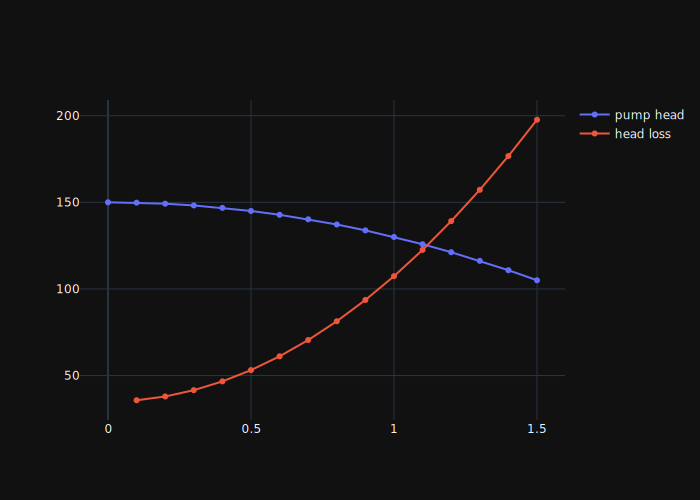

In [17]:
def get_total_system_head_throttling_m(vol_flow_m3_per_s: float, k_value: float) -> float:
    """Return the total head loss when the valve is throttled"""
    head_loss_pipe_m = get_system_head_m(vol_flow_m3_per_s)
    head_loss_valve = core.head_from_K(
        K=k_value, V=vol_flow_m3_per_s / pipe_section_area_m2, g=9.81
    )
    return head_loss_pipe_m + head_loss_valve

system_head_with_valve_m_array = np.array([
    get_total_system_head_throttling_m(vol_flow, k_value=8)
    for vol_flow in vol_flow_m3_per_s_array[1:]
])
fig = make_subplots()
fig.add_scatter(x=vol_flow_m3_per_s_array, y=pump_head_m_array, name="pump head")
fig.add_scatter(x=vol_flow_m3_per_s_array[1:], y=system_head_with_valve_m_array, name="head loss")
fig.show(renderer="svg")

In [18]:
# Find the flow exactly
def function_to_solve(vol_flow_m3_per_s: float) -> float:
    """Function to solve for flow"""
    pump_head_m = get_pump_head_m(vol_flow_m3_per_s)
    head_loss_m = get_total_system_head_throttling_m(
        vol_flow_m3_per_s, k_value=8
    )
    return pump_head_m - head_loss_m

sol = root_scalar(f=function_to_solve, x0=1.4, x1=1.3)
if sol.converged:
    vol_flow_throttling_m3_per_s = sol.root
    pump_head_throttling_m = get_pump_head_m(vol_flow_throttling_m3_per_s)
    efficiency = get_pump_efficiency(vol_flow_throttling_m3_per_s)
    power_throttling_kw = \
        fluid.density * 9.81 \
        * vol_flow_throttling_m3_per_s \
        * pump_head_throttling_m \
        / efficiency \
        / 1000
    print(f"Volume flow: {vol_flow_throttling_m3_per_s:.2f}m3/s")
    print(f"Head: {pump_head_throttling_m:.1f}m")
    print(f"Efficiency: {efficiency:.3f}")
    print(f"Power: {power_throttling_kw:.1f}kW")

Volume flow: 1.12m3/s
Head: 125.1m
Efficiency: 0.848
Power: 1612.3kW


In [19]:
# Find the k-value for reducing the flow by 50%
vol_flow_throttling_by_50_per_m3_per_s = 0.5 * vol_flow_only_pipe_m3_per_s
pump_head_throttling_by_50_per_m = get_pump_head_m(vol_flow_throttling_by_50_per_m3_per_s)
def function_to_solve(k_value: float) -> float:
    """Function to solve for k value"""
    head_loss_m = get_total_system_head_throttling_m(
        vol_flow_throttling_by_50_per_m3_per_s, k_value=k_value
    )
    return pump_head_throttling_by_50_per_m - head_loss_m

sol = root_scalar(f=function_to_solve, x0=8, x1=10)
if sol.converged:
    k_value = sol.root
    efficiency = get_pump_efficiency(vol_flow_throttling_by_50_per_m3_per_s)
    power_throttling_by_50_perc_kw = \
        fluid.density * 9.81 \
        * vol_flow_throttling_by_50_per_m3_per_s \
        * pump_head_throttling_by_50_per_m \
        / efficiency \
        / 1000
    print(f"Volume flow: {vol_flow_throttling_by_50_per_m3_per_s:.2f}m3/s")
    print(f"k value: {k_value:.2f}")
    print(f"Head: {pump_head_throttling_by_50_per_m:.1f}m")
    print(f"Efficiency: {efficiency:.3f}")
    print(f"Power: {power_throttling_by_50_perc_kw:.1f}kW")

Volume flow: 0.63m3/s
k value: 88.89
Head: 142.1m
Efficiency: 0.688
Power: 1270.8kW


## 3. Flow control by bypass

As having the valve is not very efficient way to control the flow, we decided to put the bypass line with a throttling valve after the pump that returns the flow back to the reservoir. Is it possible to achieve 50% of the flow? If not, what will be the minimum flow that is possible with the pump curve given?

============== Answer ==============

When the flow to the destination reservoir is reduced by 50%, the system head is dropped accordingly.

In [20]:
system_head_50_per = get_system_head_m(0.5 * vol_flow_only_pipe_m3_per_s)
print(f"The system head at 50% flow: {system_head_50_per:.1f}m")

The system head at 50% flow: 55.9m


This is too low head for the pump to operate. The minimum head that the pump can operate stably at this speed is 105m. With some margin, we will limit the pump to operate at minimum 100m. In practice, the system will have the throttling valve to maintain the minimum head. In our case, we will just operate the pump above this head without any throttling valve. Given that the minimum pump head is 100m, the minimum flow in the system is determined.

In [21]:
min_pump_head_m = 100
# Solve for the pump flow
def function_to_solve(vol_flow_m3_per_s: float) -> float:
    """Function to solve the equation for volume flow"""
    return min_pump_head_m - get_pump_head_m(vol_flow_m3_per_s)
sol = root_scalar(f=function_to_solve, x0=1.2, x1=1.3)
if sol.root:
    pump_vol_flow_m3_per_s = sol.root
else:
    raise ValueError
# Solve for the system flow
def function_to_solve(vol_flow_m3_per_s: float) -> float:
    """Function to solve the equation for volume flow"""
    return min_pump_head_m - get_system_head_m(vol_flow_m3_per_s)
sol = root_scalar(f=function_to_solve, x0=1.2, x1=1.3)
if sol.root:
    system_vol_flow_m3_per_s = sol.root
else:
    raise ValueError
bypass_vol_flow_m3_per_s = pump_vol_flow_m3_per_s - system_vol_flow_m3_per_s
print(f"Volume flow from pump: {pump_vol_flow_m3_per_s:.3f}m3/s")
print(f"Volume flow to destination: {system_vol_flow_m3_per_s:.3f}m3/s")
print(f"Bypass flow: {bypass_vol_flow_m3_per_s:.3f} m3/s")

efficiency = get_pump_efficiency(pump_vol_flow_m3_per_s)
power_bypass_kw = fluid.density * 9.81 \
    * min_pump_head_m \
    * pump_vol_flow_m3_per_s \
    / efficiency \
    / 1000
print(f"Efficiency: {efficiency:.3f}")
print(f"Power consumption: {power_bypass_kw:.1f}kW")




Volume flow from pump: 1.581m3/s
Volume flow to destination: 1.110m3/s
Bypass flow: 0.471 m3/s
Efficiency: 0.814
Power consumption: 1902.1kW


## 4 Flow control by speed control

We now see that the bypass control was not very economical either. We will now evaluate the option of speed control.
What will be the speed of the pump when the flow is 50% of the pump without any control? What is the power consumption?

==================== Answer ======================

The pump will follow the affinity rule since there has been no change in the geometry. The new curve for the pump with tne
new speed will be:

\begin{aligned}
H_{N_{new}} &= \left(\frac{N_{new}}{N_{1170}}\right)^2 \cdot f_{N_{1170}}\left(\frac{N_{new}}{N_{1170}} \cdot Q_{N_{New}}\right) \\
&=
\end{aligned}

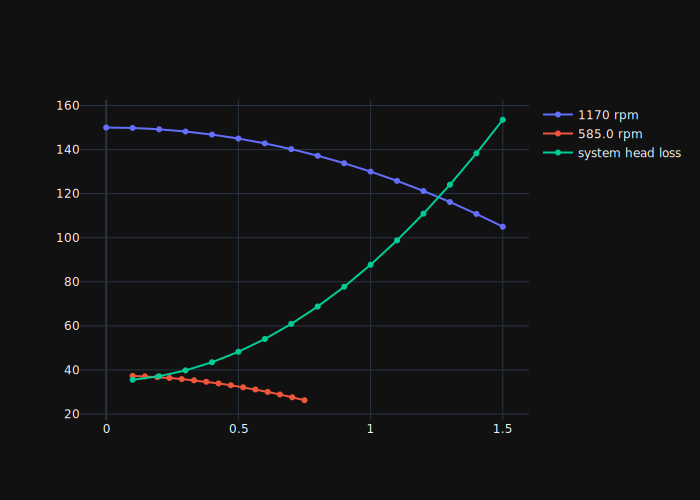

In [22]:
def get_vol_flow_from_affinity_m3_per_s(vol_flow_ref_m3_per_s: float, speed_ref_rpm: float, speed_rpm: float) -> float:
    """Returns the flow for the new speed using affinity rules"""
    return vol_flow_ref_m3_per_s * speed_rpm / speed_ref_rpm

def get_head_from_affinity_m(head_ref_m: float, speed_ref_rpm: float, speed_rpm: float) -> float:
    """Returns the head for the new speed using affinity rules"""
    return head_ref_m * np.power(speed_rpm / speed_ref_rpm, 2)

def get_pump_head_for_new_speed_m(vol_flow_m3_per_s: float, speed_rpm: float) -> float:
    """Returns the pump head for the new speed for the given flow"""
    vol_flow_at1170_m3_per_s = get_vol_flow_from_affinity_m3_per_s(vol_flow_m3_per_s, speed_ref_rpm=speed_rpm, speed_rpm=1170)
    head_at1170_m = get_pump_head_m(vol_flow_at1170_m3_per_s)
    return get_head_from_affinity_m(head_ref_m=head_at1170_m, speed_ref_rpm=1170, speed_rpm=speed_rpm)

# Let's plot when the speed is halved
speed_rpm = 1170 / 2
vol_flow_max_reduced_speed_m3_per_s = get_vol_flow_from_affinity_m3_per_s(
    vol_flow_ref_m3_per_s=vol_flow_m3_per_s_array[-1],
    speed_ref_rpm=1170,
    speed_rpm=speed_rpm
)
vol_flow_reduced_m3_per_s_array = np.linspace(0.1, vol_flow_max_reduced_speed_m3_per_s, 15)
pump_head_reduced_m_array = get_pump_head_for_new_speed_m(
    vol_flow_m3_per_s=vol_flow_reduced_m3_per_s_array,
    speed_rpm=speed_rpm
)

fig = make_subplots()
fig.add_scatter(x=vol_flow_m3_per_s_array, y=pump_head_m_array, name="1170 rpm")
fig.add_scatter(x=vol_flow_reduced_m3_per_s_array, y=pump_head_reduced_m_array, name=f"{speed_rpm} rpm")
fig.add_scatter(x=vol_flow_m3_per_s_array[1:], y=head_system_m_array, name=f"system head loss")
fig.show(renderer="svg")

To get the exact solution, we need to find the speed that satisfied the operating point of 50% flow. We get this point from the system head loss curve.

Vol flow: 0.63m3/s
head: 55.9 m
The pump speed is 763.198816020003 RPM


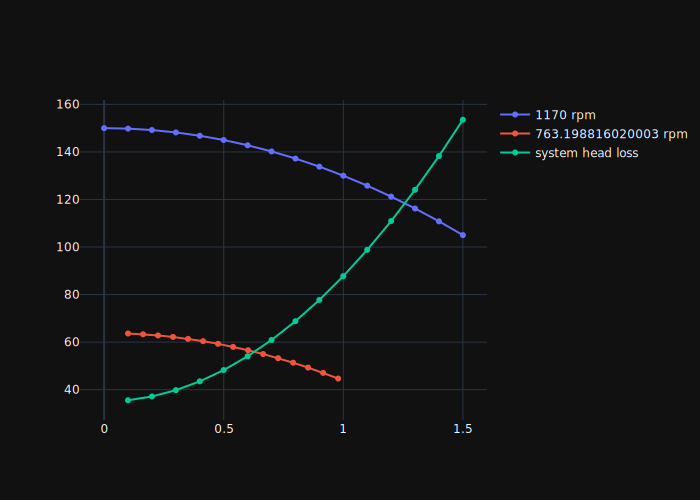

In [23]:
# Operating point
vol_flow_reduced_m3_per_s = vol_flow_only_pipe_m3_per_s * 0.5
head_required_m = get_system_head_m(vol_flow_reduced_m3_per_s)

print(f"Vol flow: {vol_flow_reduced_m3_per_s:.2f}m3/s")
print(f"head: {head_required_m:.1f} m")

# Find the pump speed that satisfies this operating condition
def function_to_solve(speed_rpm: float) -> float:
    """Function to solve for speed that satisfies the operating point"""
    pump_head_m = get_pump_head_for_new_speed_m(vol_flow_m3_per_s=vol_flow_reduced_m3_per_s, speed_rpm=speed_rpm)
    return head_required_m - pump_head_m

init_speed_rpm = 0.75 * 1170
sol = root_scalar(f=function_to_solve, x0=init_speed_rpm, x1=init_speed_rpm*0.95)
if sol.converged:
    pump_speed_new_rpm = sol.root
    print(f"The pump speed is {pump_speed_new_rpm} RPM")

vol_flow_max_reduced_speed_m3_per_s = get_vol_flow_from_affinity_m3_per_s(
    vol_flow_m3_per_s_array[-1], speed_ref_rpm=1170, speed_rpm=pump_speed_new_rpm
)
vol_flow_reduced_m3_per_s_array = np.linspace(0.1, vol_flow_max_reduced_speed_m3_per_s, 15)
pump_head_reduced_m_array = get_pump_head_for_new_speed_m(
    vol_flow_m3_per_s=vol_flow_reduced_m3_per_s_array, speed_rpm=pump_speed_new_rpm
)

fig = make_subplots()
fig.add_scatter(x=vol_flow_m3_per_s_array, y=pump_head_m_array, name="1170 rpm")
fig.add_scatter(x=vol_flow_reduced_m3_per_s_array, y=pump_head_reduced_m_array, name=f"{pump_speed_new_rpm} rpm")
fig.add_scatter(x=vol_flow_m3_per_s_array[1:], y=head_system_m_array, name=f"system head loss")
fig.show(renderer="svg")

In [24]:
# Power consumption
# For the efficiency, we can use the same efficiency as the system without control as the efficiency
# could have decreased due to reduced flow but may have increased due to reduced speed.
efficiency = get_pump_efficiency(vol_flow_only_pipe_m3_per_s)

power_reduced_speed_kw = fluid.density * 9.81 \
                         * vol_flow_reduced_m3_per_s \
                         * head_required_m \
                         / efficiency \
                         / 1000
print(f"Power consumption: {power_reduced_speed_kw:.1f} kW")

Power consumption: 401.9 kW
